In [13]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random


def seed_torch(seed=2022):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes) -> None:
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size,
                          num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0),
                         self.hidden_size).to(device)
        out, _ = self.gru(x, h0)
        return self.fc(out[:, -1, :])


def dataloader(df: pd.DataFrame, batch_size, num_steps, pre_steps):
    data = df[df.columns[1]].values
    m = data.mean()
    std = data.std()
    data = (data-m)/std
    data_len = len(data)
    num_examples = (data_len-num_steps)//num_steps
    epoch_size = num_examples//batch_size
    example_indices = list(range(num_examples))
    random.shuffle(example_indices)

    def _data(pos):
        return data[pos:pos+num_steps]

    def _data_(pos):
        return data[pos:pos+pre_steps]

    for i in range(epoch_size):
        i = i * batch_size
        batch_indices = example_indices[i:i+batch_size]
        X = np.array([_data(j*num_steps) for j in batch_indices])
        Y = np.array([_data_(j*num_steps+num_steps) for j in batch_indices])
        X = torch.from_numpy(X).float().cuda()
        Y = torch.from_numpy(Y).float().cuda()
        yield X.view(batch_size, num_steps, -1), Y





In [14]:
net = GRU(input_size=1, hidden_size=32,
          num_layers=1, num_classes=3).to(device)
df = pd.read_csv('data/LBMA-GOLD.csv')
df.dropna(inplace=True)
epochs = 2000
batch_size = 2
optimizer = optim.Adam(net.parameters(), lr=1e-5)
criterion = nn.MSELoss().to(device)
net.train()
losses = []
for e in range(epochs):
    net.train()
    total_train_loss = 0
    dl = dataloader(df, batch_size=2, num_steps=7, pre_steps=3)
    for i, (x, y) in enumerate(dl):
        y_pred = net(x)
        loss = criterion(y_pred, y)
        total_train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'epoch[{e+1}/{epochs}] loss:{total_train_loss}')
    losses.append(total_train_loss)

torch.save(net, 'gru_gold.pth')

epoch[1/2000] loss:85.81128946691751
epoch[2/2000] loss:85.13416381180286
epoch[3/2000] loss:84.44166034460068
epoch[4/2000] loss:83.75326430052519
epoch[5/2000] loss:83.06233625952154
epoch[6/2000] loss:82.37052274867892
epoch[7/2000] loss:81.67410720232874
epoch[8/2000] loss:80.97351121902466
epoch[9/2000] loss:80.26360197365284
epoch[10/2000] loss:79.54349659383297
epoch[11/2000] loss:78.82073890417814
epoch[12/2000] loss:78.08397561125457
epoch[13/2000] loss:77.34065283369273
epoch[14/2000] loss:76.57922851108015
epoch[15/2000] loss:75.80387005209923
epoch[16/2000] loss:75.02304629981518
epoch[17/2000] loss:74.22237742692232
epoch[18/2000] loss:73.4067857414484
epoch[19/2000] loss:72.58007252216339
epoch[20/2000] loss:71.73411422083154
epoch[21/2000] loss:70.87358384206891
epoch[22/2000] loss:69.98497525462881
epoch[23/2000] loss:69.08419545646757
epoch[24/2000] loss:68.16225706413388
epoch[25/2000] loss:67.22018461767584
epoch[26/2000] loss:66.25328293442726
epoch[27/2000] loss:65

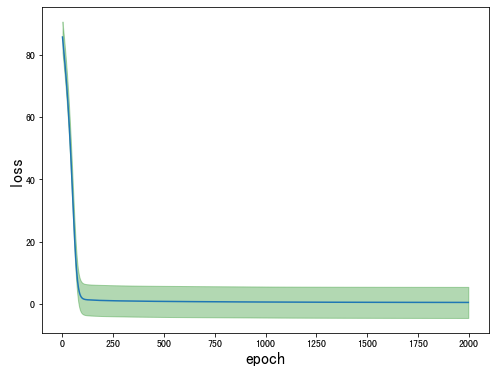

In [15]:
import matplotlib.pyplot as plt
_=plt.figure(figsize=(8,6))
losses=np.array(losses)
plt.plot(losses)
plt.xlabel('epoch',fontsize=16)
plt.ylabel('loss',fontsize=16)
plt.fill_between(list(range(2000)),losses-5,losses+5,alpha=0.3,color='g')
plt.savefig('mseloss_bit.jpg')

In [ ]:
losses

array([138.29655008, 136.98137091, 135.67672965, ...,   0.5776186 ,
         0.57607204,   0.57765303])